## MC simulations of fluids

In [38]:
import matplotlib.pyplot as plt

import numpy as np
from itertools import product

from ipywidgets import interact
import plotly.express as px
from numba import jit, njit

## LJ model of a simple fluids, noble gases


**Check out reference values of [LJ fluid properties tabulated by NIST](https://www.nist.gov/mml/csd/chemical-informatics-research-group/lennard-jones-fluid-properties)**



Density, temperature and unitcell number can be used to fully speify a lattice packed with LJ particles 

In [39]:
#------- Simulation parameters ----
rho    = .88 # Density of Argon in natural units
T_0    = 1   # Temperature
N_cell = 3   # Number of unitcells in one direction    

#------- All else is inferred from simulation params -------
N      = 4 * N_cell ** 3 # the total number of particles in the system
L_box  = (N / rho) ** (1 / 3) # length of the whole box
L_cell =  L_box / N_cell # length of a unitcell

### Initializing the system, watch out for clashes!

In [40]:
def IC_pos(L_cell, N_cell):
  '''Create lattice of LJ particles positioned
  ---
  N_cell: # number of unitcells in one direction  
  L_cell: # length of a unitcell, which is box-length/N_cell
  '''

  pos = [[[x,  y, z], [x, 0.5 + y, 0.5 + z], [0.5 + x, y, 0.5 + z], [0.5 + x, 0.5 + y, z]] 
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    
  pos = np.array(pos).reshape((-1, 3))

  return pos * L_cell

In [104]:
pos = IC_pos(L_cell, N_cell)

px.scatter_3d(x=pos[:,0], y=pos[:,1], z=pos[:,2], opacity=0.5)

### [Periodic Boundary conditions and minimum image criterion](https://en.wikipedia.org/wiki/Periodic_boundary_conditions)

- If a particle leaves the box, it re-enters at the opposite side.
- What should be the distance between partiles? There is some mbiguity because distance between atoms may now include crossing the system boundary and re-entering. This is identical to introducing copies of the particles around the simulation box. We adopt **minimum image convention** by choosing the shortest distance possible


![](./pbc_fig1.gif)

![](./pbc_fig2.gif)

- By adopting minimum image convention we consider the closest of all 'image partners' (plus the original) of every atom for calculating interaction. The animation below highlights the image partners of the two red atoms that are closest to the green atom. 

- To minimize distance between points we evaluate distances along x, y and z dimension and choose the smallest possible one. 


In [42]:
def pbc_basic(x, L):
  '''For a box centered at the origin. This pbc function for wrapping positions of particles back into the into the box. 
  This function should also be used for dx displacements to obey minimum image criterion. 
  '''
    
  if   x >=  L/2: x -= L  

  elif x <= -L/2: x += L

  return x


@njit
def pbc_wrap(r_vec, L_box):
    '''For a box with origin at a corner this function implements minimum image convention 
    by identifying smallest distances for an array of dz, dy, dz displacements/
    r_vec: np.array([x,y,z]) 
    L_box: float, 
    '''
    
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box
    
    return r_vec

### Computing pairwise distances and energies

In [66]:
@njit
def getE_tot(pos, 
             L, 
             trunc, 
             sig=1, eps=1):
    '''Compute Total energy by summing all pairwise interactions of LJ fluid'''
    
    N = len(pos)
    energy = 0

    r_sq_list = []
    
    for i in range(0, N-1):
        for j in range(i+1, N):

          r_vec = pbc_wrap(pos[i]-pos[j], L)

          r_sq = np.sum(r_vec**2)

          if r_sq <= trunc**2:
                
            energy += 4 * eps * ( (sig/r_sq)**6 - (sig/r_sq)**3 )

          r_sq_list.append(r_sq)

    return energy, r_sq_list
    
@njit
def E_disp(pos, 
           L, 
           trunc, 
           j, r_j, 
           sig=1, eps=1):
    '''Compute energy resulting from displacing a tagged particle j by a small incremenet delta'''
    
    N = len(pos)
    energy = 0

    #iterate over neighbours of tagged particle j
    nbs = [i for i in range(N) if i!=j]

    for i in nbs:

      r_vec = pbc_wrap(pos[i] - r_j, L)

      r_sq = np.sum(r_vec**2)
      
      if r_sq <= trunc**2:
                
        energy += 4* eps * ( (sig/r_sq)**6 - (sig/r_sq)**3 )

    return energy

### MC engine for LJ fluid in 3D (NVT ensemble)
Now that the main helper functions are set up we can put together a main Monte Carlo engine that loops through randomly selected particles and attemps their displacement via Metropolis Criterion. 

In [67]:
@njit
def run_MC_LJ(pos, rho, T, trunc=4, disp=0.5, steps=10000, freq=1000):

    # initialize variables

    N      = len(pos)
    L      = ( N / rho ) ** (1/3)
    
    E_tot, r_sq_list   = getE_tot(pos, L, trunc)
    es      = [E_tot]
    hists   = []
    confs   = [pos.copy()] 
    
    # Loop through MC steps
    for step in range(int(steps)):
        
        # Randomly choose some particle i in  
        j     = np.random.randint(N)
        
        # Give particle j a random push delta,
        delta = np.random.uniform(-disp, disp, size=3)
        
        # Positions with PBC enforced
        r_j       = np.mod(pos[j], L )
        r_j_new   = np.mod(pos[j] + delta, L)

        # Evaluate energy change due to particle displacement
        dE = E_disp(pos, L, trunc, j, r_j_new) - E_disp(pos, L, trunc, j, r_j)

        # Metropolis acceptance/rejection condition
        if  np.exp(-dE/T) > np.random.rand():
       
            pos[j] = r_j_new
            
        if step % freq ==0:

            E_tot, r_sq_list  = getE_tot(pos, L, trunc)
            H, _ = np.histogram(np.array(r_sq_list), bins=30, range=(0, L / 2))

            hists.append(H)
            es.append(E_tot)
            confs.append(pos.copy())

    return confs, es, hists

### Running MCMC simulation on LJ system

In [68]:
#------- Simulation parameters ----
rho    = .88 # Density of Argon in natural units
T      = 1   # Temperature
N_cell = 3   # Number of unitcells in one direction    

#------- All else is inferred from simulation params -------
N      = 4 * N_cell ** 3 # the total number of particles in the system
L_box  = (N / rho) ** (1 / 3) # length of the whole box
L_cell =  L_box / N_cell # length of a unitcell

In [100]:
%time 

pos = IC_pos(L_cell, N_cell)

confs, es, hists = run_MC_LJ(pos, rho, T, steps = int(1e6),  freq=100)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


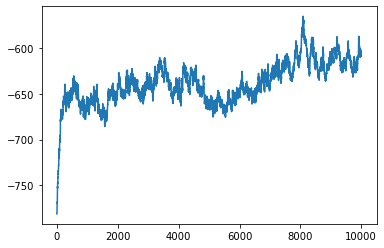

In [101]:
plt.plot(es)

In [102]:
@interact(i=(0, 1000-1))
def viz_sim_lj(i=0):

  fig = px.scatter_3d(x=confs[i][:,0], y=confs[i][:,1], z=confs[i][:,2], opacity=0.5)

  return fig

interactive(children=(IntSlider(value=0, description='i', max=999), Output()), _dom_classes=('widget-interact'…

<ipython-input-125-76b05bf3ab5d>:3: RuntimeWarning:

invalid value encountered in true_divide



Text(0, 0.5, '$g(r)$')

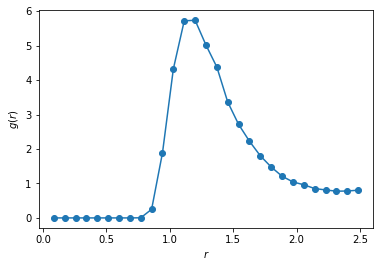

In [125]:
r = np.linspace(0, L_box / 2, 30)

pair_correlation = np.mean(hists, axis=0) / (4 * np.pi * rho * r)

plt.plot(r, pair_correlation, '-o') 
plt.xlabel(r'$r$')  
plt.ylabel(r'$g(r)$')

### Problems

**1. Implementing PBC and minimal image convention methods outlined on  [Wikipeida](https://en.wikipedia.org/wiki/Periodic_boundary_conditions) in python.**

- Write a few functions that take positions of N particles in 3D with shape (N,3) return new coordinates and all inter-particle distances. 
> You can generate random positions using ```np.random``` make sure you have enough particles outside of box to test your functions. 
> Try implementing your functions using numpy methods instead of having multiple for loops. That way your functions will run singnificantly faster.


```python
def pbc_dists(pos, L):

    ...
    
    return pos, dists

```

 - Evaluate distribution of energies of your random positions before and after applying pbc_dists.
 
 
**2. Simulating 2D random walk with PBCs.**

 - Create a sequence of images or better yet an animation showing the temporal evolution of 10 independent random walkers in 100 by 100 square. Consult the random walk section and notebooks to refresh your memory of random walk simulations.
 - Calculate the root mean square displacement from the origin and show how it scales with time (steps)!
  
 
**2. Run MC simulations of LJ fluid at several temperatures to identify critical temperature.**

 - At each temperature evaluate heat capacity and RDFs.
 - Plot how energy, heat capacity and RDF change as a function of temperature.
 - Study dependence on sampling efficiency on magnitude of particle displacement.